<a href="https://colab.research.google.com/github/yuhyunchoi0521/HER2-Virtual-Screen-v1/blob/main/HER2_Virtual_Screen_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HER2-Virtual-Screen-v1
## Building an automated data pipeline that queries the ChEMBL API to perform virtual screening on 50+ lead candidates for HER2-targeted therapies, applying Lipinski’s Rule of Five to assess oral bioavailability.
### Lipinski's Rule of Five: Lipinski's Rule is used to predict if a drug candidate has the physical properties to be successfully absorbed by the human body as an oral pill. A molecule is generally considered "drug-like" if:
Molecular Weight: $\leq 500$ Da<br>LogP (Octanol-water partition): $\leq 5$ <br>H-Bond Donors: $\leq 5$<br>H-Bond Acceptors: $\leq 10$
<br>Citation: Lipinski, Christopher A., et al. “Experimental and Computational Approaches to Estimate Solubility and Permeability in Drug Discovery and Development Settings.” *Advanced Drug Delivery Reviews*, vol. 23, no. 1-3, Jan. 1997, pp. 3–25, https://doi.org/10.1016/s0169-409x(96)00423-1.

In [6]:
%%capture
!pip install rdkit
!pip install chembl_webresource_client

# 1.
import base64 # a binary-to-text encoding scheme that converts binary data (like images, files) into a sequence of printable ASCII characters (A-Z, a-z, 0-9, +, /)
from io import BytesIO
from IPython.display import HTML

# 2.
from chembl_webresource_client.new_client import new_client

# 3.
from rdkit import Chem # rdkit: Open-Source Cheminformatics Software
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

# 4.
import pandas as pd # pandas: Python library for data analysis
from IPython.display import display, HTML

# 5.
import matplotlib.pyplot as plt

In [7]:
# 1. Helper function to convert RDKit image to an HTML string
def mol_to_html(mol):
    img = Draw.MolToImage(mol, size=(400, 200))
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f'<img src="data:image/png;base64,{img_str}"/>'

In [8]:
# 2. ChEMBL API Input Data

# 2_1. Initialize the ChEMBL search for 'HER2' (a common drug target)
target = new_client.target
activity = new_client.activity
her2 = target.filter(target_synonym__icontains='HER2')[0]
her2_id = her2['target_chembl_id']

# 2_2. Get 50 activities (molecules) related to this target
# whether a datum have a SMILES string
raw_data = activity.filter(target_chembl_id=her2_id).only(['molecule_chembl_id', 'canonical_smiles'])[:100]

# 2_3. Convert this into your 'compounds' list format automatically
compounds = []
for data in raw_data:
    if data['canonical_smiles']:
        compounds.append({
            'name': data['molecule_chembl_id'],
            'smiles': data['canonical_smiles']
        })
print(f"Successfully downloaded {len(compounds)} molecules from ChEMBL")
'''
SMILES (Simplified Molecular Input Line Entry System)
a text-based notation that represents a molecule's structure as a short, linear string of ASCII characters
'''

Successfully downloaded 100 molecules from ChEMBL


"\nSMILES (Simplified Molecular Input Line Entry System)\na text-based notation that represents a molecule's structure as a short, linear string of ASCII characters\n"

,Name,Structure,MW,LogP,Pass
0,CHEMBL68920,,384,4,✅
1,CHEMBL68920,,384,4,✅
2,CHEMBL69960,,483,4,✅
3,CHEMBL69960,,483,4,✅
4,CHEMBL67057,,560,5,❌
5,CHEMBL67057,,560,5,❌
6,CHEMBL65848,,471,3,✅
7,CHEMBL65848,,471,3,✅
8,CHEMBL69629,,526,3,❌
9,CHEMBL69629,,526,3,❌

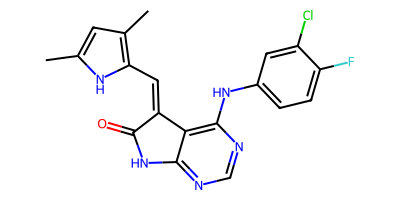
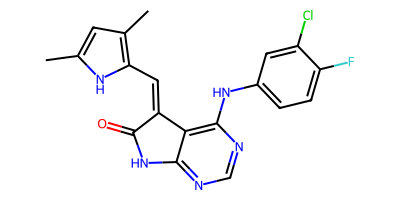
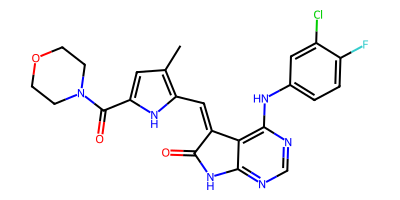
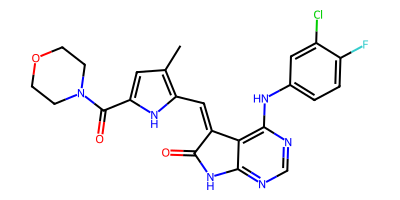
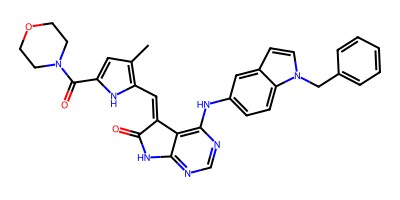
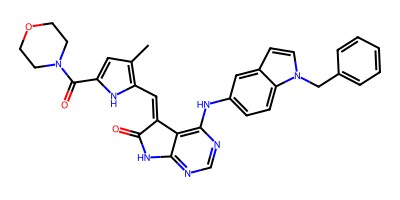
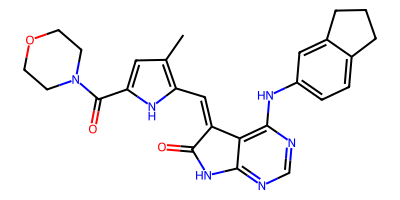
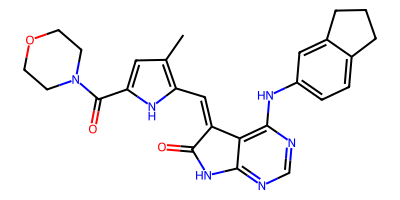
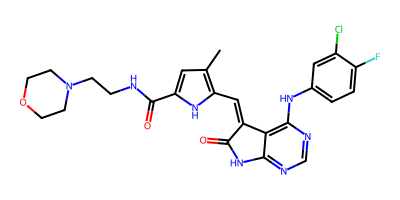
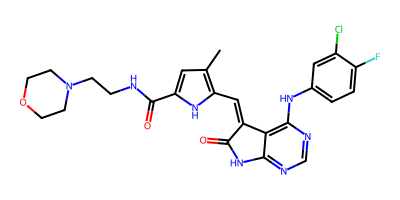
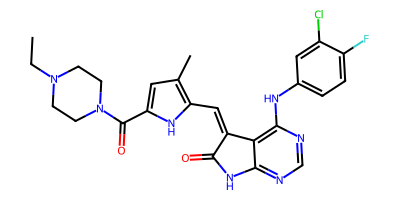
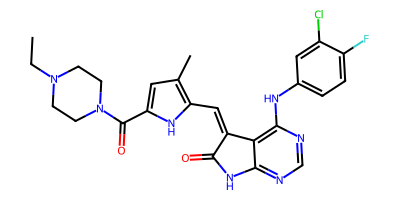
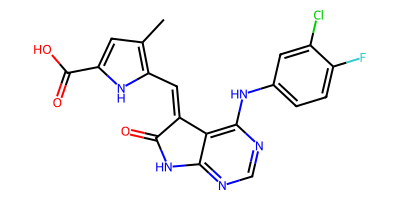
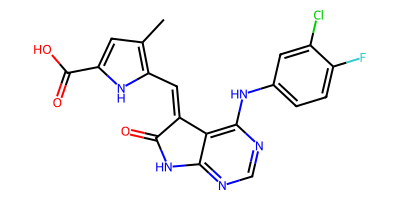
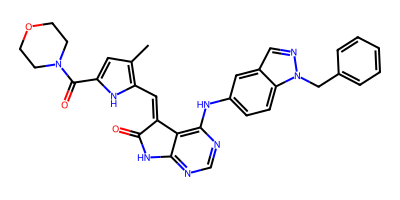
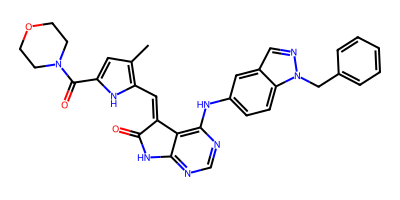
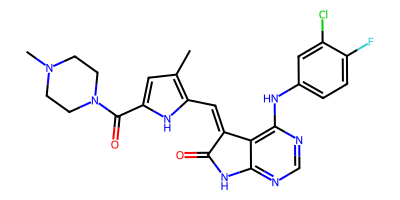
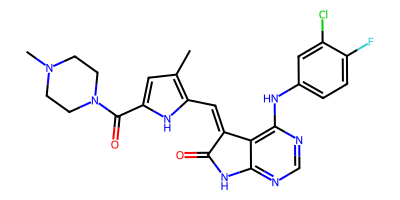
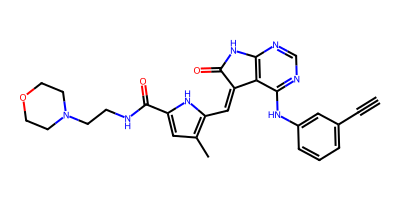
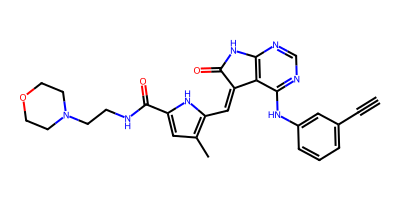
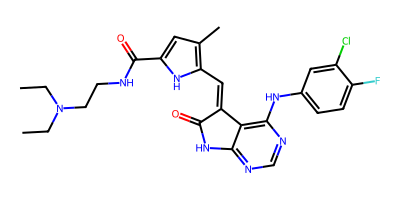
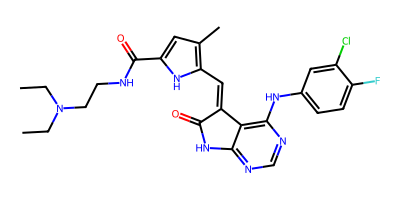
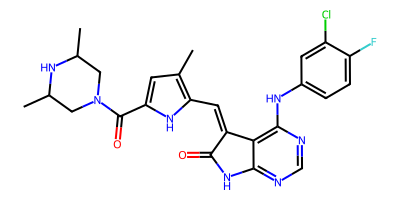
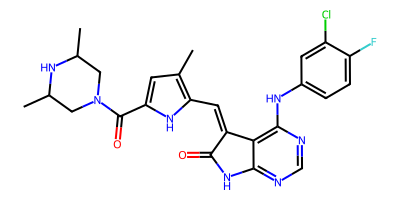
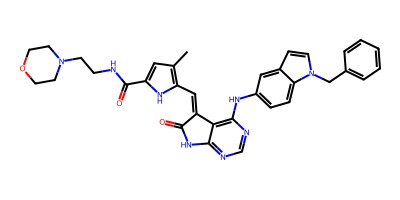
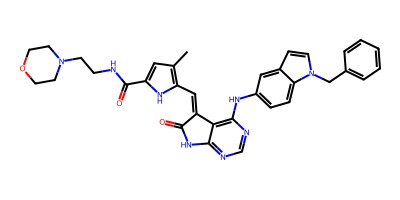
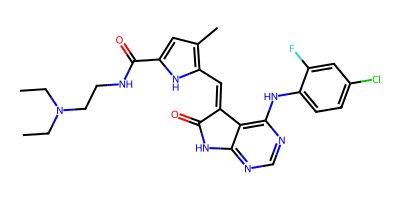
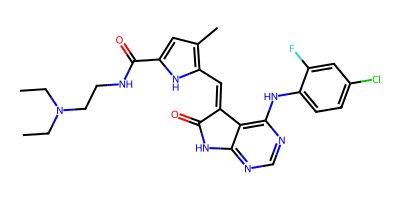
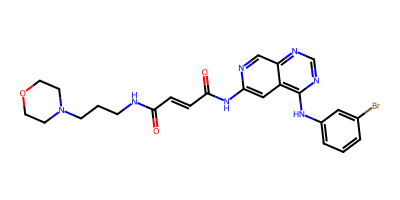
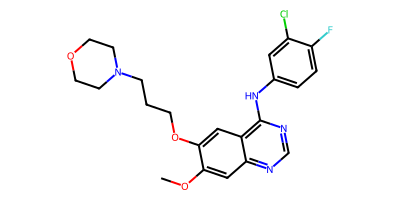
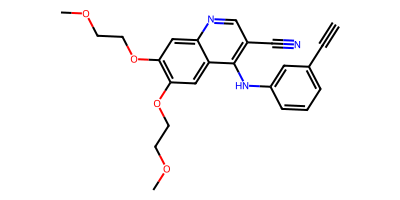
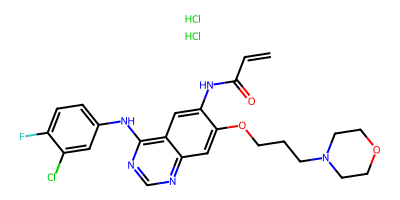
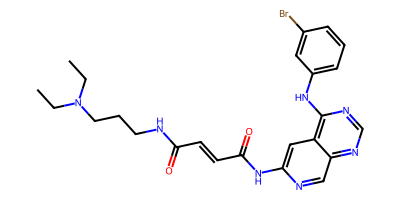
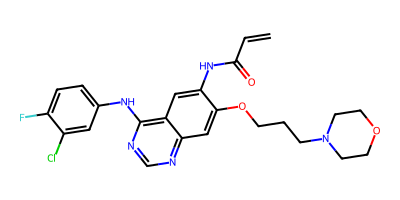
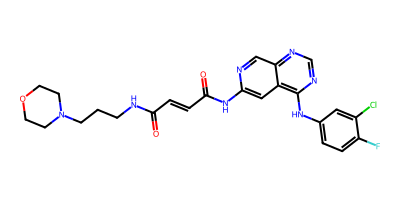
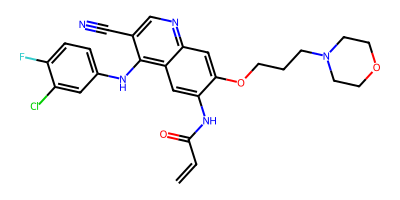
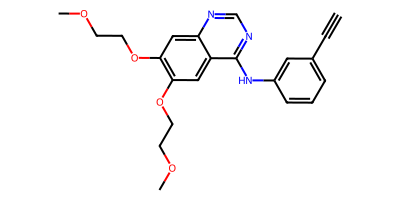
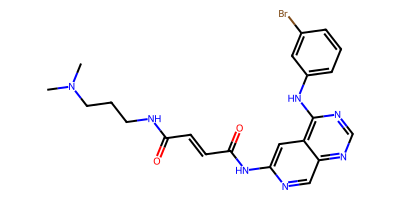
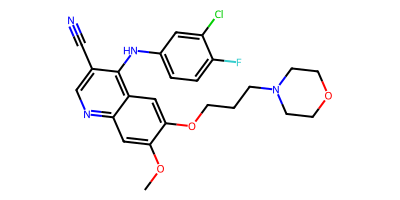
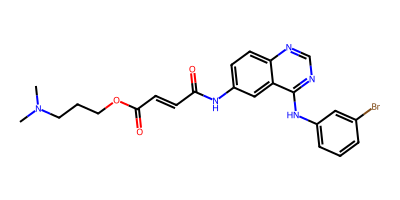
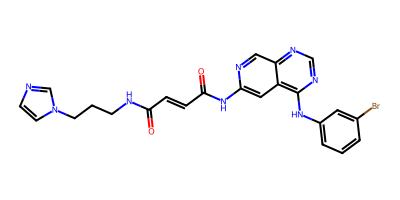
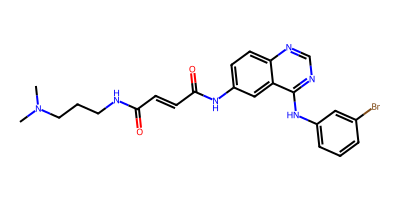
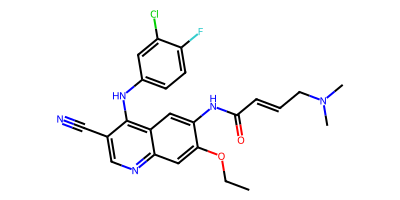
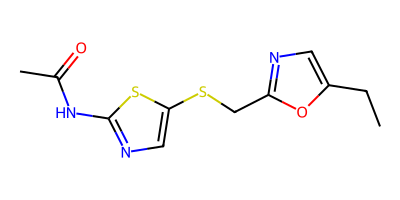
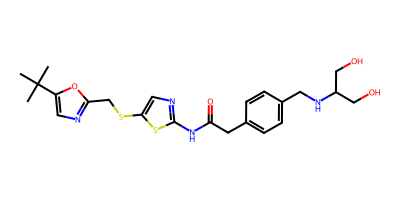
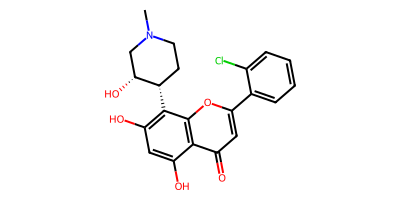
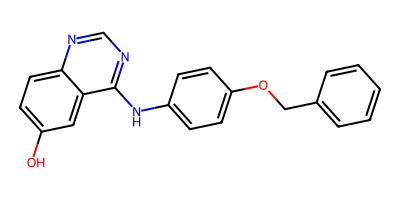
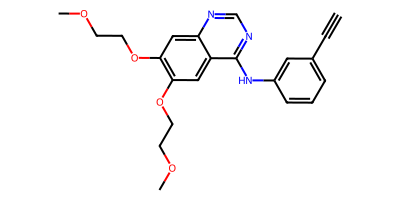
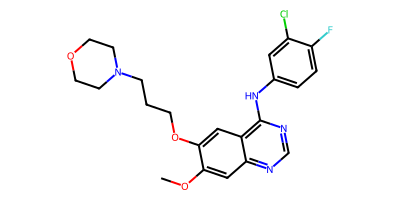
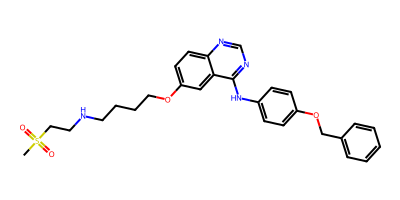
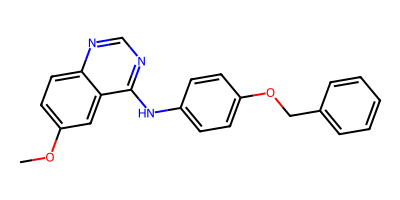
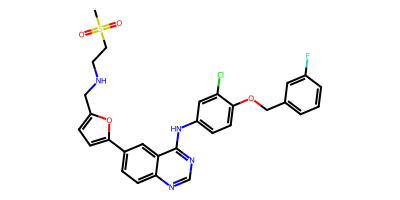
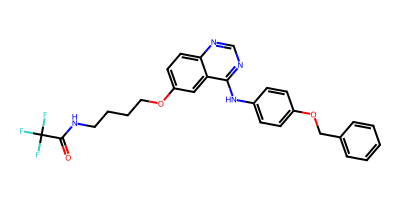
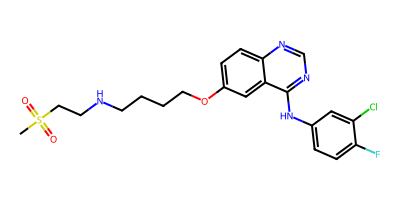
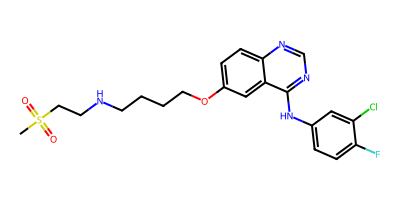
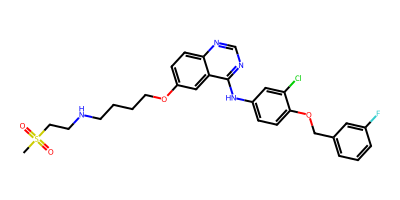
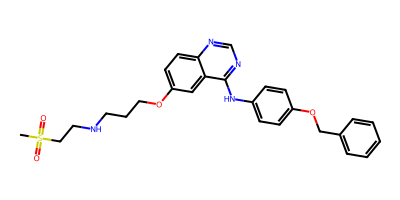
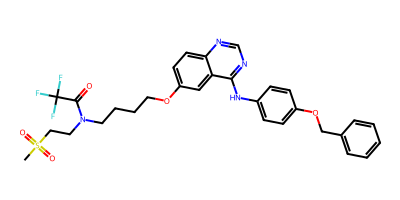
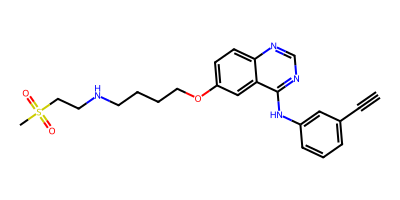
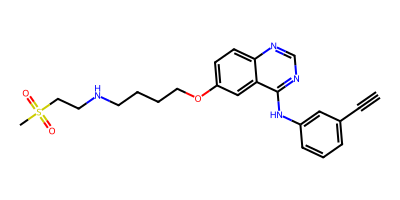
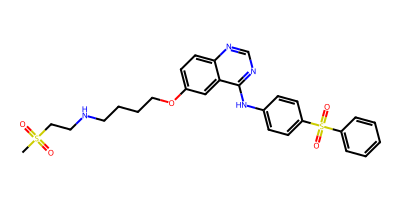
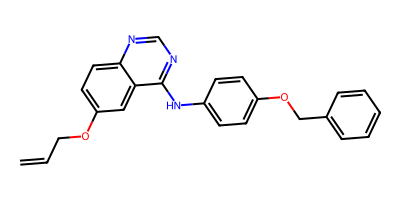
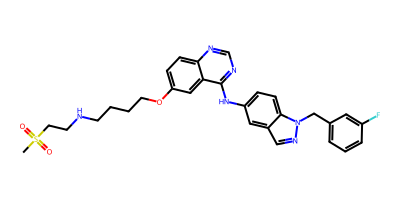
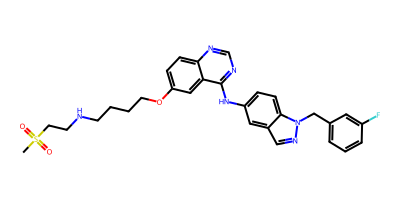
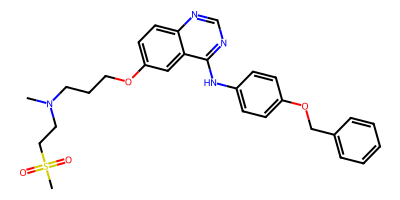
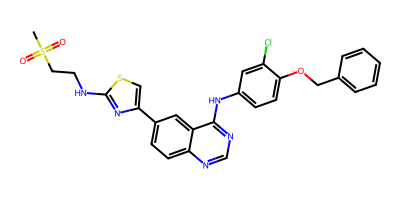
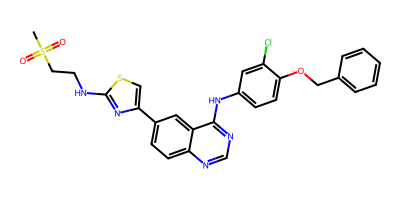
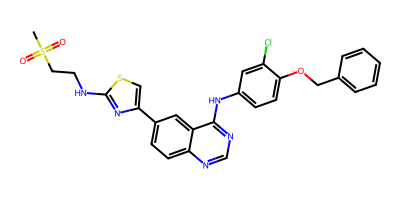
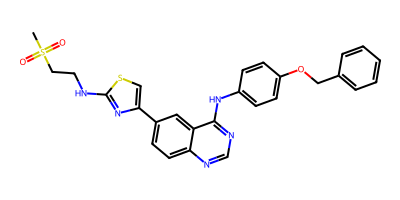
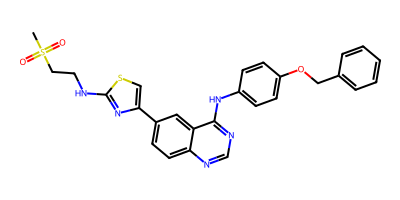
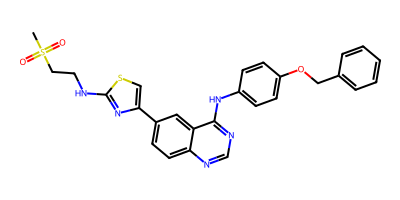
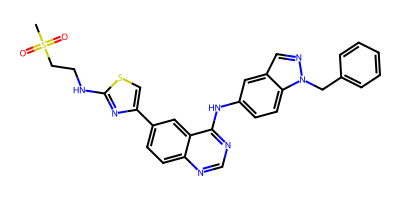
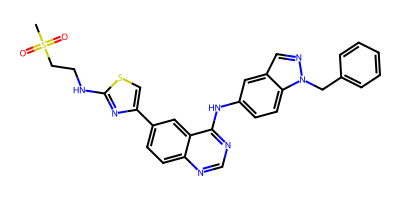
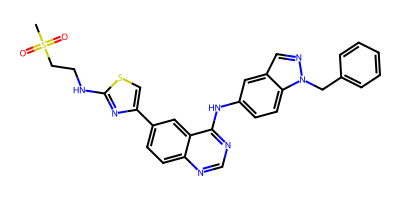
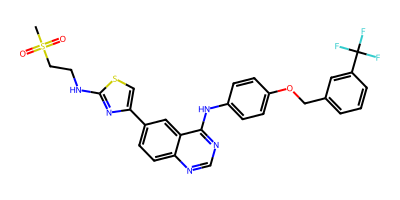
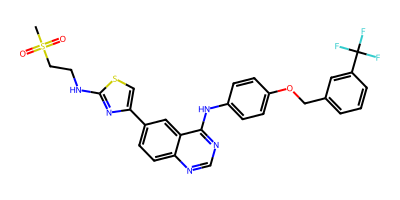
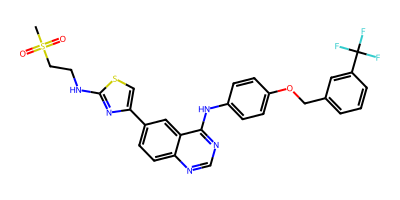
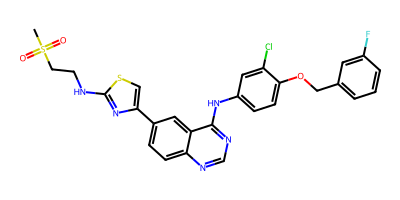
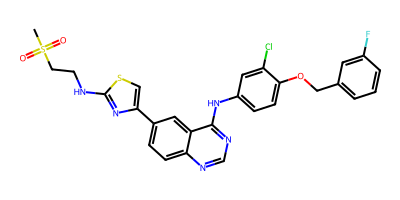
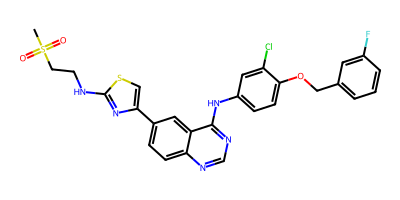
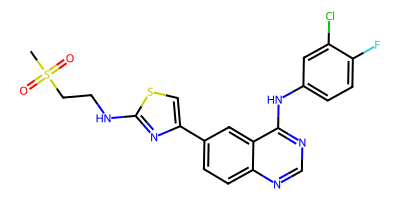
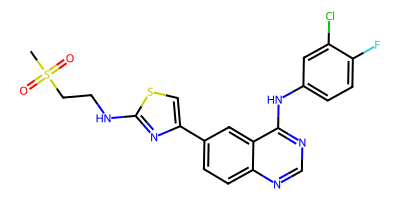
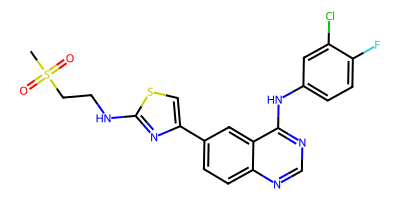
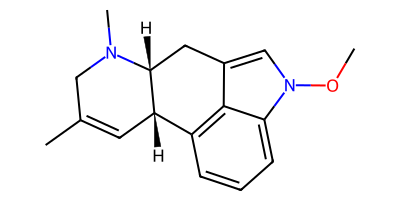
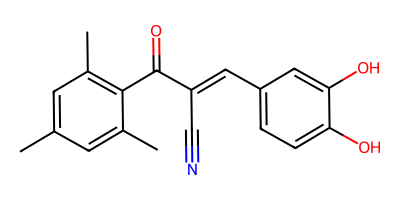
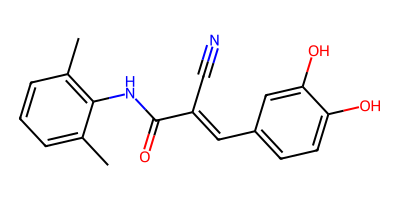
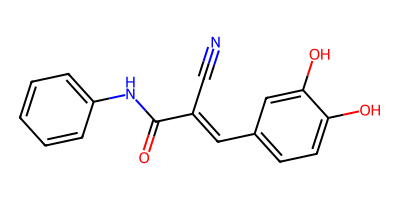
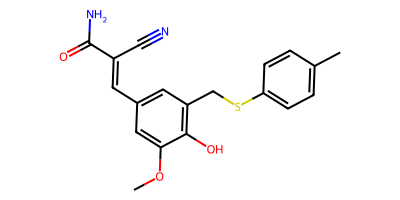
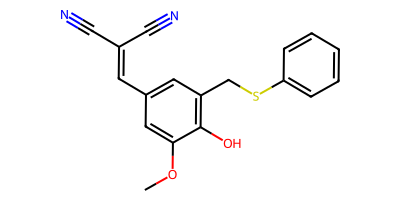
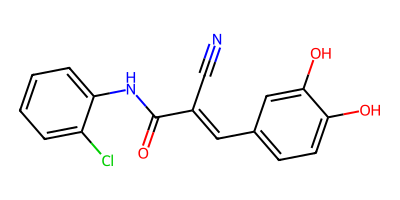
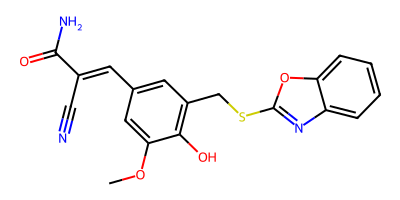
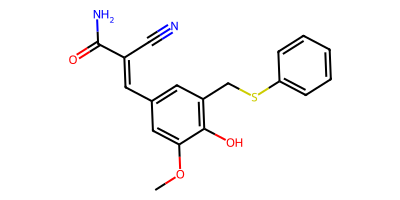
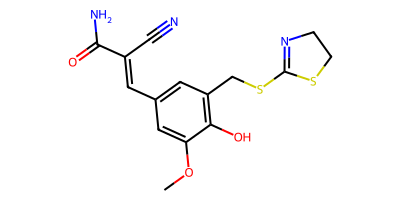
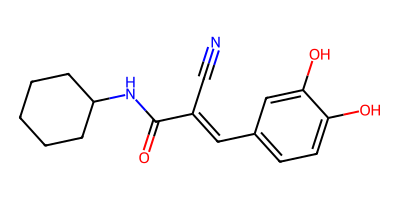
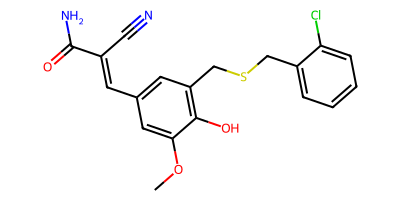
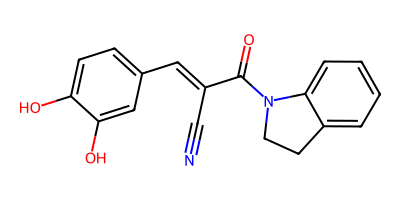
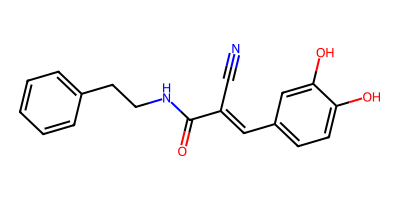
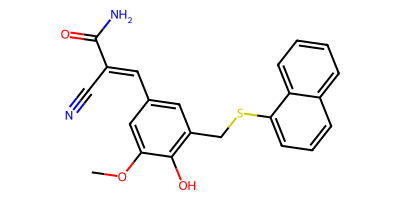
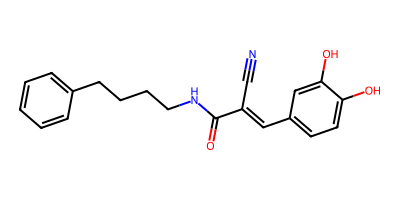
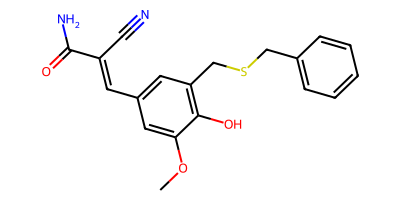

In [9]:
# 3. The Logic
results = []
for compound in compounds:
    mol = Chem.MolFromSmiles(compound['smiles'])

    # Calculate descriptors using RDKit
    molecular_weight = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)

    # Check against the Rule of 5
    drug_likable = molecular_weight <= 500 and logp <= 5 and h_donors <= 5 and h_acceptors <= 10

    # Store result in a dictionary (Hash Table!)
    results.append({
        'Name': compound['name'],
        'Structure': mol_to_html(mol), # Store as HTML string
        'MW': round(molecular_weight),
        'LogP': round(logp),
        'Pass': '✅' if drug_likable else '❌'
    })


# 4. View as a Professional Table
df = pd.DataFrame(results)
display(HTML(df.to_html(escape=False))) # This tells Colab to render the HTML tags

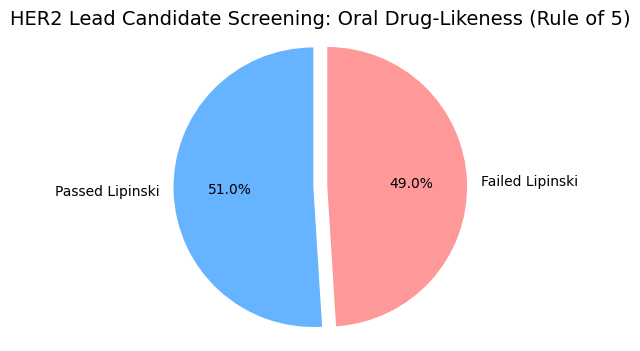

In [10]:
# 5. Generate a result pie chart

# 5-1. Count how many passed and how many failed
# This is like a LeetCode "Frequency Count" problem!
pass_count = df['Pass'].value_counts().get('✅', 0)
fail_count = df['Pass'].value_counts().get('❌', 0)

# 5-2. Data for the chart
labels = ['Passed Lipinski', 'Failed Lipinski']
sizes = [pass_count, fail_count]
colors = ['#66b3ff', '#ff9999'] # Professional blue and soft red
explode = (0.1, 0)  # "Pop out" the Passed slice for emphasis

# 5-3. Create the Pie Chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90)

plt.title('HER2 Lead Candidate Screening: Oral Drug-Likeness (Rule of 5)', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# 5-4. Show the chart
plt.show()